In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, plot_confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import nltk
import transformers
from nltk.corpus import stopwords
sw_nltk = stopwords.words('english')
from gensim.models import Word2Vec, word2vec
from transformers import BertTokenizer, AutoTokenizer, BertModel, BertConfig, AutoModel, AdamW
from transformers import DistilBertTokenizer
from PIL import Image
import natsort
import os
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.colors as colors
from matplotlib.collections import PatchCollection
import transformers
import os
import pandas as pd
import natsort
import numpy as np
from PIL import Image
import requests
import torch
from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode
import clip

import torch
from transformers import AutoTokenizer, DistilBertModel
import time
import random
import tensorflow as tf
import transformers
import os
import pandas as pd
import natsort
import numpy as np
from PIL import Image
import time
import tensorflow as tf
from tensorflow import keras
from keras import layers, models
from keras.losses import mse
from keras import backend as K
from tensorflow.keras.layers import Dropout
TF_ENABLE_ONEDNN_OPTS=0

2023-07-15 11:33:46.513191: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


## BASIC UTIL FUNCTION

In [2]:
def export_classification_report(report, mod, exec_time):
    lines = report.split('\n')
    data = lines[2:4] + lines[5:9]
    data = [line.split() for line in data]
    

    acc = float(data[2][1])
    m_prec = float(data[3][2])
    m_recall = float(data[3][3])
    m_f1 = float(data[3][4])
    w_prec = float(data[4][2])
    w_recall = float(data[4][3])
    w_f1 = float(data[4][4])
    
    df = pd.DataFrame({
        'Model': [mod],
        'Accuracy': [acc],
        'M-Precision': [m_prec],
        'M-Recall': [m_recall],
        'M-F1-Score': [m_f1],
        'W-Precision': [w_prec],
        'W-Recall': [w_recall],
        'W-F1-Score': [w_f1],
        'Runtime': [exec_time]
    })
    
    return df
# Function to apply text perturbation
def apply_text_perturbation(text):
    words = text.split()  # Split the text into words
    perturbed_words = []
    for word in words:
        # Apply perturbation to each word
        if random.random() < 0.2:  # 20% chance of perturbing a word
            perturbed_word = ""
            for char in word:
                if char in ["a", "e", "i", "o", "u"]:
                    perturbed_char = chr(ord(char) + 32)  # Replace vowel with a space
                else:
                    perturbed_char = char
                perturbed_word += perturbed_char

            perturbed_words.append(perturbed_word)
    perturbed_text = " ".join(perturbed_words)  # Join the perturbed words back into a text
    return perturbed_text

## DATA PREPARATION

In [3]:
# Load the data


#  DistilBERT Embeddings (Text Only); (Train and Test Data Embeddings)

train2 = pd.read_csv('./training1.csv', delimiter='\t')

IDs = []  #set1
images = []
directory = 'TRAINING'   # directory where we have images 
filenames = natsort.natsorted(os.listdir(directory))  

# get the ids from the images, where images are having three channels; omit images if channels != 3
for i, filename in enumerate(filenames):
#     print(i, filename)
    if filename.endswith(".jpg"):
#         ID = int(filename[:-4])
        ID = filename
        pathname = os.path.join(directory, filename)
        im = Image.open(pathname)
        im = im.resize((224, 224))  # Resize the image to (224, 224)
        imnp = np.array(im)
        if len(imnp.shape) != 3:
#             print("This is 1 channel, so we omit it", imnp.shape, filename)
            continue
        IDs.append(ID)
        images.append(imnp)

def get_common_strings(list1, list2):
    return list(set(list1) & set(list2))

# Example usage
list1 = IDs
list2 = list(train2.file_name)  #from the text file where we have text description 
common_strings = get_common_strings(list1, list2)
print('len of common strings', len(common_strings))

sorted_ids = natsort.natsorted(common_strings)

# print(sorted_ids)

# Sort the dataframe with natural ordering of the IDs
train2['prefix_file_name'] = train2['file_name'].str.extract('(\d+)').astype(int)
# Assuming 'df' is your DataFrame
sorted_train_df = train2.sort_values(by='prefix_file_name', ascending=True)
sorted_train_df

# Assuming 'df' is your DataFrame and 'common_strings' is the list of strings
# Get the common string values in the column 
filtered_df = sorted_train_df[sorted_train_df['file_name'].isin(sorted_ids)].reset_index(drop=True)

# Print the filtered DataFrame
print('filtered_df shape', filtered_df.shape)

train3 = filtered_df.copy()
# print(train3.shape)

trainx = train3.rename(columns={'Text Transcription': 'text'})
# display(trainx)



### LOAD TEST DATA

test1 = pd.read_csv('Test.csv', delimiter='\t')
test_labels = pd.read_csv('test_labels.txt', 
                          delimiter='\t',
                         header=None)

test_labels.columns = ['file_name', 
                      "misogynous",
                       "shaming",
                       "stereotype",
                       "objectification",
                       "violence"]

merged_test = pd.merge(test1, test_labels, on='file_name', how='inner')


# Sort the dataframe with natural ordering of the IDs
merged_test['prefix_file_name'] = merged_test['file_name'].str.extract('(\d+)').astype(int)
# Assuming 'df' is your DataFrame
merged_test1 = merged_test.sort_values(by='prefix_file_name', ascending=True)
merged_test1


# # train = train.rename(columns={'Text Transcription': 'text'})
test2 = merged_test1.rename(columns={'Text Transcription': 'text'})
# test2



# ######################################################
train = trainx[['file_name', 'text', 'misogynous']]
train = train.rename(columns = {'misogynous':'label'})

test = test2[['file_name', 'text', 'misogynous']]
test = test.rename(columns = {'misogynous':'label'})

train['label'] = train['label'].map({0: 'non_misogyn', 1: 'misogyn'})
test['label'] = test['label'].map({0: 'non_misogyn', 1: 'misogyn'})
display(train)
display(test)

len of common strings 9986
filtered_df shape (9986, 8)


,file_name,text,label
0,1.jpg,Milk Milk.zip,non_misogyn
1,2.jpg,-What are you doing? -you told me to satanize ...,non_misogyn
2,3.jpg,imgflip.com ME 1254 NEW BUGS AFTER CHANGES BUG...,non_misogyn
3,4.jpg,Bedroom Kitchen Bathroom Bron memes storage,non_misogyn
4,5.jpg,WAKEUP EARLY FREELANCERS,non_misogyn
...,...,...,...
9981,15002.jpg,WAITING FOR THE END OF THE COVID imgflip.com,non_misogyn
9982,15003.jpg,SMART WOMEN ARE AROUND imgflip.com,non_misogyn
9983,15004.jpg,GOOD GIRLS ARE BEHIND THE CORNER imgflip.com,non_misogyn
9984,15005.jpg,COOKING FOR MY WIFE imgflip.com,non_misogyn


,file_name,text,label
436,15001.jpg,G HIS. UNDYING FIDELITY Steve is hot and perfe...,non_misogyn
854,15002.jpg,How limagined myself as a Teacher...... How I ...,non_misogyn
743,15004.jpg,WHERE WILL YOU BE WHEN DIARRHEA STRIKE memecen...,non_misogyn
44,15005.jpg,A MAN WITH DREAMS... NEEDS A WOMAN WITH VISION,non_misogyn
873,15006.jpg,THIS IS HOW YOUR GIRLFRIEND SEES YOUR FEMALE F...,non_misogyn
...,...,...,...
871,17078.jpg,There are multiple reasons to lower your car T...,non_misogyn
683,17079.jpg,MICHELLE OBAMA IS A MAN IGUARANTEE IT makeamem...,misogyn
406,17080.jpg,Looks like the airbags deployed 1234498,non_misogyn
733,17081.jpg,Half woman half horse,non_misogyn


## ALL THREE METHODS RUN FOR FEATURE EXTRACTION

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


train embeddings shape: (9986, 64)
test embeddings shape: (1000, 64)
transformer version: 4.15.0
cuda
NVIDIA GeForce RTX 3070 Laptop GPU
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
len of common strings 9986
torch.Size([9986, 512])
Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 512)]        0           []                               
                                                                                                  
 dense (Dense)                  (None, 128)          65664       ['encoder_input[0][0]']          
                                                                                                  
 dropout (Dropout)              (None, 128)          0           ['dense[0][0]']                  
                                                        

2023-07-15 11:40:40.176064: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-15 11:40:40.238464: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-15 11:40:40.238662: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-15 11:40:40.239376: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the approp

Epoch 1/10
 40/313 [==>...........................] - ETA: 1s - loss: 119.4529 - kl_loss: 2.0395 - mse_loss: 117.4133

2023-07-15 11:40:41.188295: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


313/313 [==============================] - 2s 4ms/step - loss: 83.0528 - kl_loss: 0.6604 - mse_loss: 82.3924
Epoch 2/10
313/313 [==============================] - 1s 3ms/step - loss: 74.5166 - kl_loss: 0.5422 - mse_loss: 73.9744
Epoch 3/10
313/313 [==============================] - 1s 3ms/step - loss: 73.1524 - kl_loss: 0.6445 - mse_loss: 72.5079
Epoch 4/10
313/313 [==============================] - 1s 3ms/step - loss: 72.2434 - kl_loss: 0.7333 - mse_loss: 71.5101
Epoch 5/10
313/313 [==============================] - 1s 4ms/step - loss: 71.6072 - kl_loss: 0.8051 - mse_loss: 70.8020
Epoch 6/10
313/313 [==============================] - 1s 4ms/step - loss: 71.1933 - kl_loss: 0.8467 - mse_loss: 70.3466
Epoch 7/10
313/313 [==============================] - 1s 4ms/step - loss: 70.6936 - kl_loss: 0.8959 - mse_loss: 69.7978
Epoch 8/10
313/313 [==============================] - 1s 4ms/step - loss: 70.3008 - kl_loss: 0.9254 - mse_loss: 69.3755
Epoch 9/10
313/313 [==============================]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Fusion Embeddings Train (9986, 192)
Fusion Embeddings Test (1000, 192)


/home/nitesh/env/dev38/python38/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


[0]	validation_0-error:0.19955	validation_0-logloss:0.68455	validation_1-error:0.24575	validation_1-logloss:0.68578
[1]	validation_0-error:0.19317	validation_0-logloss:0.67628	validation_1-error:0.23974	validation_1-logloss:0.67880
[2]	validation_0-error:0.18891	validation_0-logloss:0.66828	validation_1-error:0.23624	validation_1-logloss:0.67198
[3]	validation_0-error:0.18928	validation_0-logloss:0.66051	validation_1-error:0.23624	validation_1-logloss:0.66552
[4]	validation_0-error:0.18640	validation_0-logloss:0.65304	validation_1-error:0.23523	validation_1-logloss:0.65918
[5]	validation_0-error:0.18590	validation_0-logloss:0.64584	validation_1-error:0.23223	validation_1-logloss:0.65291
[6]	validation_0-error:0.18490	validation_0-logloss:0.63881	validation_1-error:0.22623	validation_1-logloss:0.64712
[7]	validation_0-error:0.18603	validation_0-logloss:0.63205	validation_1-error:0.22573	validation_1-logloss:0.64129
[8]	validation_0-error:0.18252	validation_0-logloss:0.62548	validation_1

[71]	validation_0-error:0.13170	validation_0-logloss:0.40663	validation_1-error:0.19970	validation_1-logloss:0.47161
[72]	validation_0-error:0.13182	validation_0-logloss:0.40470	validation_1-error:0.19970	validation_1-logloss:0.47058
[73]	validation_0-error:0.13020	validation_0-logloss:0.40289	validation_1-error:0.20020	validation_1-logloss:0.46941
[74]	validation_0-error:0.13095	validation_0-logloss:0.40106	validation_1-error:0.19920	validation_1-logloss:0.46845
[75]	validation_0-error:0.13107	validation_0-logloss:0.39930	validation_1-error:0.19920	validation_1-logloss:0.46738
[76]	validation_0-error:0.13207	validation_0-logloss:0.39749	validation_1-error:0.19720	validation_1-logloss:0.46620
[77]	validation_0-error:0.13057	validation_0-logloss:0.39573	validation_1-error:0.19870	validation_1-logloss:0.46502
[78]	validation_0-error:0.13057	validation_0-logloss:0.39408	validation_1-error:0.19770	validation_1-logloss:0.46412
[79]	validation_0-error:0.12982	validation_0-logloss:0.39235	val

[141]	validation_0-error:0.10203	validation_0-logloss:0.31297	validation_1-error:0.19269	validation_1-logloss:0.42603
[142]	validation_0-error:0.10178	validation_0-logloss:0.31200	validation_1-error:0.19269	validation_1-logloss:0.42566
[143]	validation_0-error:0.10103	validation_0-logloss:0.31093	validation_1-error:0.19269	validation_1-logloss:0.42531
[144]	validation_0-error:0.10140	validation_0-logloss:0.31020	validation_1-error:0.19319	validation_1-logloss:0.42505
[145]	validation_0-error:0.10078	validation_0-logloss:0.30910	validation_1-error:0.19269	validation_1-logloss:0.42469
[146]	validation_0-error:0.10028	validation_0-logloss:0.30817	validation_1-error:0.19219	validation_1-logloss:0.42449
[147]	validation_0-error:0.09965	validation_0-logloss:0.30743	validation_1-error:0.19219	validation_1-logloss:0.42423
[148]	validation_0-error:0.09902	validation_0-logloss:0.30641	validation_1-error:0.19219	validation_1-logloss:0.42385
[149]	validation_0-error:0.09852	validation_0-logloss:0.

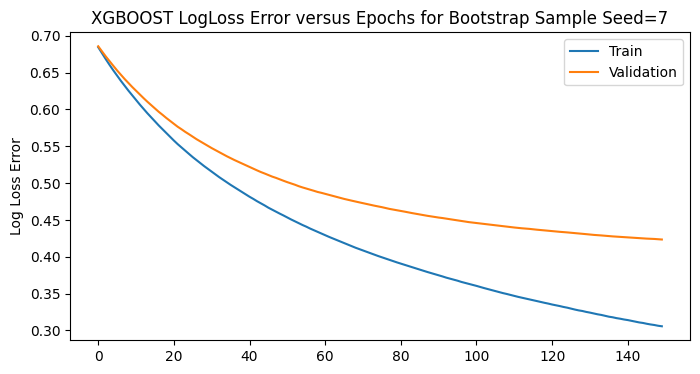

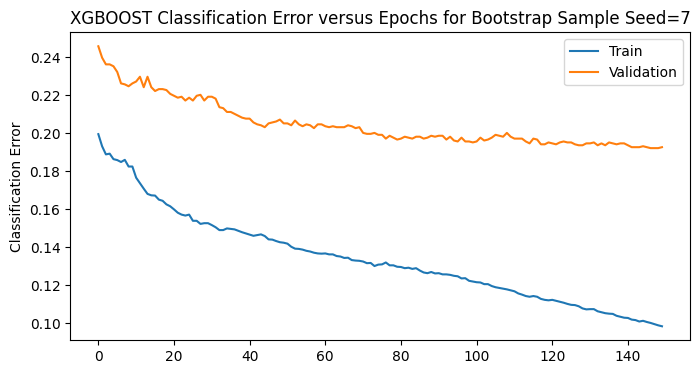

/tmp/ipykernel_9117/757353089.py:536: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  xgboost_clsfn_errrep = xgboost_clsfn_errrep.append(row_data, ignore_index=True)


              precision    recall  f1-score   support

           0       0.86      0.46      0.60       500
           1       0.63      0.93      0.75       500

    accuracy                           0.69      1000
   macro avg       0.75      0.69      0.68      1000
weighted avg       0.75      0.69      0.68      1000

Execution time: 474.5287070274353 seconds


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


train embeddings shape: (9986, 64)
test embeddings shape: (1000, 64)
transformer version: 4.15.0
cuda
NVIDIA GeForce RTX 3070 Laptop GPU
Memory Usage:
Allocated: 0.0 GB
Cached:    0.4 GB
len of common strings 9986
torch.Size([9986, 512])
Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 512)]        0           []                               
                                                                                                  
 dense_5 (Dense)                (None, 128)          65664       ['encoder_input[0][0]']          
                                                                                                  
 dropout_2 (Dropout)            (None, 128)          0           ['dense_5[0][0]']                
                                                        

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Fusion Embeddings Train (9986, 192)
Fusion Embeddings Test (1000, 192)
[0]	validation_0-error:0.19955	validation_0-logloss:0.68495	validation_1-error:0.23974	validation_1-logloss:0.68625
[1]	validation_0-error:0.19429	validation_0-logloss:0.67704	validation_1-error:0.23323	validation_1-logloss:0.67961
[2]	validation_0-error:0.18578	validation_0-logloss:0.66949	validation_1-error:0.23173	validation_1-logloss:0.67336
[3]	validation_0-error:0.18615	validation_0-logloss:0.66216	validation_1-error:0.23473	validation_1-logloss:0.66742
[4]	validation_0-error:0.18277	validation_0-logloss:0.65515	validation_1-error:0.23624	validation_1-logloss:0.66165
[5]	validation_0-error:0.18378	validation_0-logloss:0.64827	validation_1-error:0.23173	validation_1-logloss:0.65592
[6]	validation_0-error:0.18165	validation_0-logloss:0.64163	validation_1-error:0.23073	validation_1-logloss:0.65037
[7]	validation_0-error:0.18115	validation_0-logloss:0.63514	validation_1-error:0.23123	validation_1-logloss:0.64492
[

[70]	validation_0-error:0.12631	validation_0-logloss:0.41562	validation_1-error:0.20120	validation_1-logloss:0.48005
[71]	validation_0-error:0.12657	validation_0-logloss:0.41385	validation_1-error:0.20070	validation_1-logloss:0.47911
[72]	validation_0-error:0.12544	validation_0-logloss:0.41175	validation_1-error:0.20020	validation_1-logloss:0.47783
[73]	validation_0-error:0.12544	validation_0-logloss:0.41002	validation_1-error:0.19970	validation_1-logloss:0.47680
[74]	validation_0-error:0.12531	validation_0-logloss:0.40822	validation_1-error:0.20170	validation_1-logloss:0.47585
[75]	validation_0-error:0.12431	validation_0-logloss:0.40658	validation_1-error:0.19920	validation_1-logloss:0.47501
[76]	validation_0-error:0.12381	validation_0-logloss:0.40477	validation_1-error:0.19920	validation_1-logloss:0.47394
[77]	validation_0-error:0.12293	validation_0-logloss:0.40276	validation_1-error:0.20020	validation_1-logloss:0.47282
[78]	validation_0-error:0.12319	validation_0-logloss:0.40110	val

[140]	validation_0-error:0.09502	validation_0-logloss:0.31937	validation_1-error:0.18769	validation_1-logloss:0.43004
[141]	validation_0-error:0.09427	validation_0-logloss:0.31826	validation_1-error:0.18969	validation_1-logloss:0.42964
[142]	validation_0-error:0.09439	validation_0-logloss:0.31755	validation_1-error:0.18919	validation_1-logloss:0.42935
[143]	validation_0-error:0.09452	validation_0-logloss:0.31649	validation_1-error:0.18769	validation_1-logloss:0.42884
[144]	validation_0-error:0.09389	validation_0-logloss:0.31551	validation_1-error:0.18819	validation_1-logloss:0.42849
[145]	validation_0-error:0.09276	validation_0-logloss:0.31446	validation_1-error:0.18769	validation_1-logloss:0.42806
[146]	validation_0-error:0.09289	validation_0-logloss:0.31359	validation_1-error:0.18819	validation_1-logloss:0.42766
[147]	validation_0-error:0.09302	validation_0-logloss:0.31270	validation_1-error:0.18619	validation_1-logloss:0.42725
[148]	validation_0-error:0.09226	validation_0-logloss:0.

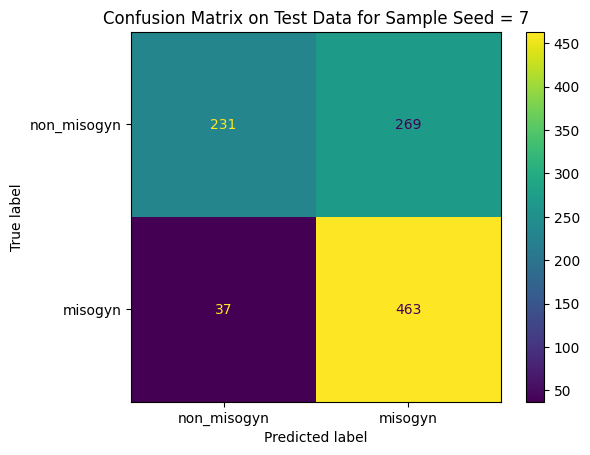

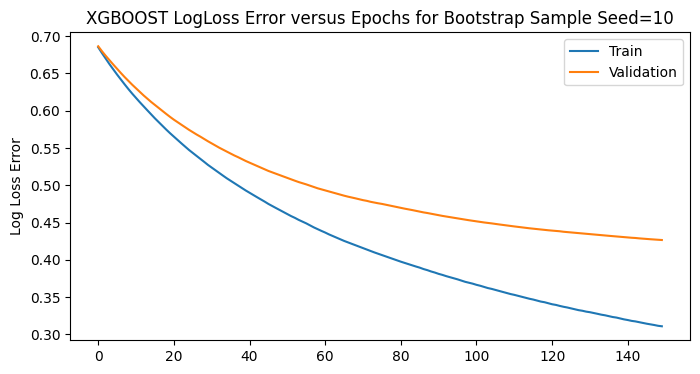

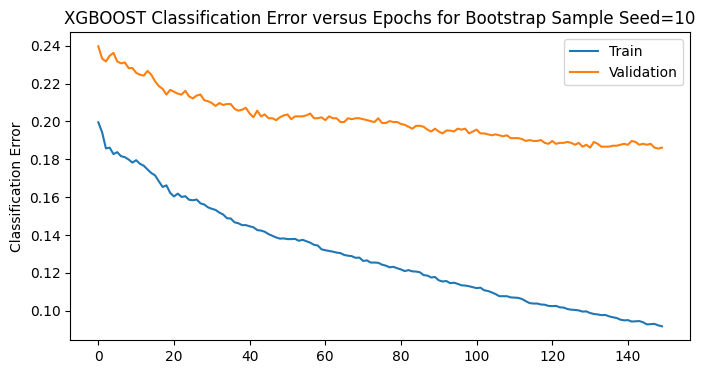

/tmp/ipykernel_9117/757353089.py:536: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  xgboost_clsfn_errrep = xgboost_clsfn_errrep.append(row_data, ignore_index=True)


              precision    recall  f1-score   support

           0       0.86      0.51      0.64       500
           1       0.65      0.91      0.76       500

    accuracy                           0.71      1000
   macro avg       0.75      0.71      0.70      1000
weighted avg       0.75      0.71      0.70      1000

Execution time: 449.78073239326477 seconds


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


train embeddings shape: (9986, 64)
test embeddings shape: (1000, 64)
transformer version: 4.15.0
cuda
NVIDIA GeForce RTX 3070 Laptop GPU
Memory Usage:
Allocated: 0.0 GB
Cached:    0.4 GB
len of common strings 9986
torch.Size([9986, 512])
Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 512)]        0           []                               
                                                                                                  
 dense_10 (Dense)               (None, 128)          65664       ['encoder_input[0][0]']          
                                                                                                  
 dropout_4 (Dropout)            (None, 128)          0           ['dense_10[0][0]']               
                                                        

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Fusion Embeddings Train (9986, 192)
Fusion Embeddings Test (1000, 192)
[0]	validation_0-error:0.18352	validation_0-logloss:0.68419	validation_1-error:0.26276	validation_1-logloss:0.68587
[1]	validation_0-error:0.17652	validation_0-logloss:0.67550	validation_1-error:0.26326	validation_1-logloss:0.67897
[2]	validation_0-error:0.17414	validation_0-logloss:0.66712	validation_1-error:0.25726	validation_1-logloss:0.67196
[3]	validation_0-error:0.17251	validation_0-logloss:0.65912	validation_1-error:0.25175	validation_1-logloss:0.66559
[4]	validation_0-error:0.17276	validation_0-logloss:0.65129	validation_1-error:0.25375	validation_1-logloss:0.65918
[5]	validation_0-error:0.17025	validation_0-logloss:0.64360	validation_1-error:0.25476	validation_1-logloss:0.65301
[6]	validation_0-error:0.16913	validation_0-logloss:0.63618	validation_1-error:0.24524	validation_1-logloss:0.64695
[7]	validation_0-error:0.16687	validation_0-logloss:0.62904	validation_1-error:0.24575	validation_1-logloss:0.64124
[

[70]	validation_0-error:0.12869	validation_0-logloss:0.40166	validation_1-error:0.21221	validation_1-logloss:0.47636
[71]	validation_0-error:0.12757	validation_0-logloss:0.39972	validation_1-error:0.21121	validation_1-logloss:0.47542
[72]	validation_0-error:0.12769	validation_0-logloss:0.39787	validation_1-error:0.21221	validation_1-logloss:0.47439
[73]	validation_0-error:0.12707	validation_0-logloss:0.39612	validation_1-error:0.21021	validation_1-logloss:0.47330
[74]	validation_0-error:0.12644	validation_0-logloss:0.39407	validation_1-error:0.21071	validation_1-logloss:0.47230
[75]	validation_0-error:0.12544	validation_0-logloss:0.39234	validation_1-error:0.21071	validation_1-logloss:0.47134
[76]	validation_0-error:0.12419	validation_0-logloss:0.39038	validation_1-error:0.20971	validation_1-logloss:0.47034
[77]	validation_0-error:0.12456	validation_0-logloss:0.38865	validation_1-error:0.21021	validation_1-logloss:0.46943
[78]	validation_0-error:0.12481	validation_0-logloss:0.38681	val

[140]	validation_0-error:0.09890	validation_0-logloss:0.30749	validation_1-error:0.20020	validation_1-logloss:0.43241
[141]	validation_0-error:0.09890	validation_0-logloss:0.30666	validation_1-error:0.19970	validation_1-logloss:0.43219
[142]	validation_0-error:0.09840	validation_0-logloss:0.30567	validation_1-error:0.19920	validation_1-logloss:0.43181
[143]	validation_0-error:0.09840	validation_0-logloss:0.30480	validation_1-error:0.19970	validation_1-logloss:0.43148
[144]	validation_0-error:0.09777	validation_0-logloss:0.30362	validation_1-error:0.19970	validation_1-logloss:0.43121
[145]	validation_0-error:0.09765	validation_0-logloss:0.30282	validation_1-error:0.19920	validation_1-logloss:0.43099
[146]	validation_0-error:0.09715	validation_0-logloss:0.30194	validation_1-error:0.19920	validation_1-logloss:0.43063
[147]	validation_0-error:0.09664	validation_0-logloss:0.30104	validation_1-error:0.19920	validation_1-logloss:0.43004
[148]	validation_0-error:0.09652	validation_0-logloss:0.

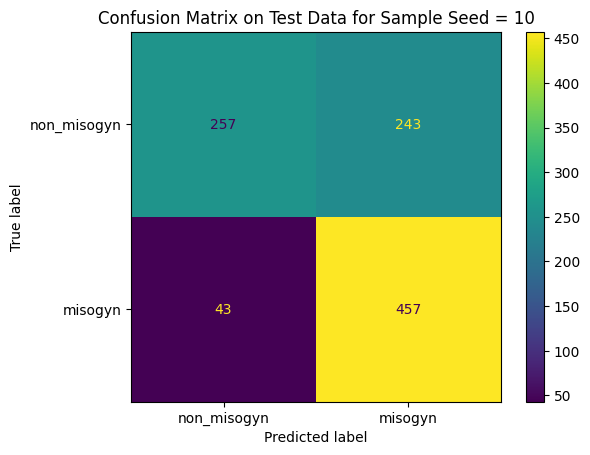

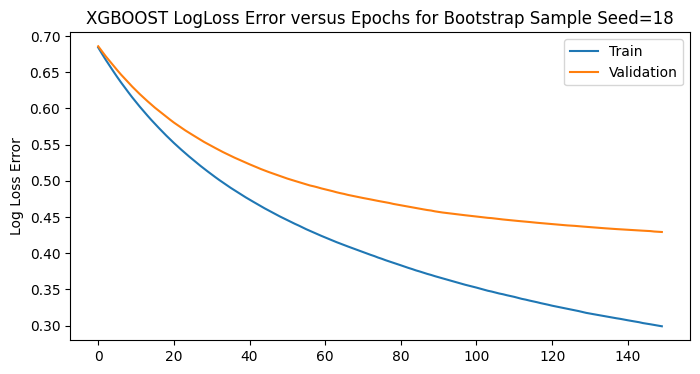

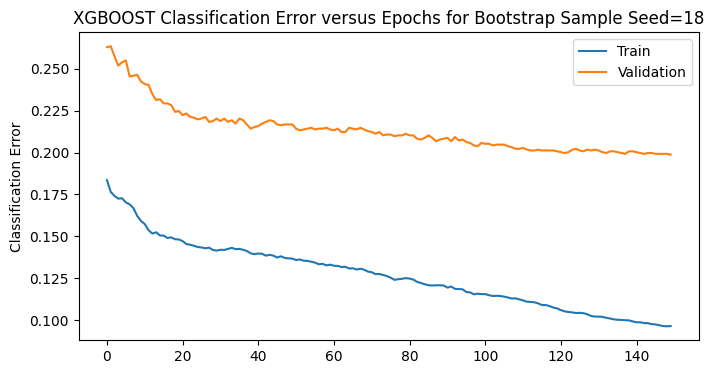

/tmp/ipykernel_9117/757353089.py:536: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  xgboost_clsfn_errrep = xgboost_clsfn_errrep.append(row_data, ignore_index=True)


              precision    recall  f1-score   support

           0       0.88      0.55      0.67       500
           1       0.67      0.92      0.78       500

    accuracy                           0.73      1000
   macro avg       0.77      0.74      0.73      1000
weighted avg       0.77      0.73      0.73      1000

Execution time: 308.29300928115845 seconds


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


train embeddings shape: (9986, 64)
test embeddings shape: (1000, 64)
transformer version: 4.15.0
cuda
NVIDIA GeForce RTX 3070 Laptop GPU
Memory Usage:
Allocated: 0.0 GB
Cached:    0.4 GB
len of common strings 9986
torch.Size([9986, 512])
Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 512)]        0           []                               
                                                                                                  
 dense_15 (Dense)               (None, 128)          65664       ['encoder_input[0][0]']          
                                                                                                  
 dropout_6 (Dropout)            (None, 128)          0           ['dense_15[0][0]']               
                                                        

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Fusion Embeddings Train (9986, 192)
Fusion Embeddings Test (1000, 192)
[0]	validation_0-error:0.20356	validation_0-logloss:0.68515	validation_1-error:0.25225	validation_1-logloss:0.68643
[1]	validation_0-error:0.19905	validation_0-logloss:0.67746	validation_1-error:0.25375	validation_1-logloss:0.67996
[2]	validation_0-error:0.20093	validation_0-logloss:0.67009	validation_1-error:0.25526	validation_1-logloss:0.67380
[3]	validation_0-error:0.19579	validation_0-logloss:0.66299	validation_1-error:0.24775	validation_1-logloss:0.66801
[4]	validation_0-error:0.19216	validation_0-logloss:0.65612	validation_1-error:0.25125	validation_1-logloss:0.66247
[5]	validation_0-error:0.18803	validation_0-logloss:0.64938	validation_1-error:0.24424	validation_1-logloss:0.65702
[6]	validation_0-error:0.18578	validation_0-logloss:0.64299	validation_1-error:0.24274	validation_1-logloss:0.65190
[7]	validation_0-error:0.18340	validation_0-logloss:0.63659	validation_1-error:0.23974	validation_1-logloss:0.64662
[

[70]	validation_0-error:0.12844	validation_0-logloss:0.41720	validation_1-error:0.20971	validation_1-logloss:0.48907
[71]	validation_0-error:0.12782	validation_0-logloss:0.41496	validation_1-error:0.20871	validation_1-logloss:0.48772
[72]	validation_0-error:0.12669	validation_0-logloss:0.41294	validation_1-error:0.20921	validation_1-logloss:0.48665
[73]	validation_0-error:0.12694	validation_0-logloss:0.41104	validation_1-error:0.20721	validation_1-logloss:0.48551
[74]	validation_0-error:0.12657	validation_0-logloss:0.40923	validation_1-error:0.20771	validation_1-logloss:0.48438
[75]	validation_0-error:0.12619	validation_0-logloss:0.40707	validation_1-error:0.20871	validation_1-logloss:0.48308
[76]	validation_0-error:0.12544	validation_0-logloss:0.40516	validation_1-error:0.20671	validation_1-logloss:0.48189
[77]	validation_0-error:0.12469	validation_0-logloss:0.40330	validation_1-error:0.20721	validation_1-logloss:0.48073
[78]	validation_0-error:0.12494	validation_0-logloss:0.40156	val

[140]	validation_0-error:0.09877	validation_0-logloss:0.31984	validation_1-error:0.19670	validation_1-logloss:0.43678
[141]	validation_0-error:0.09815	validation_0-logloss:0.31890	validation_1-error:0.19620	validation_1-logloss:0.43658
[142]	validation_0-error:0.09752	validation_0-logloss:0.31777	validation_1-error:0.19520	validation_1-logloss:0.43606
[143]	validation_0-error:0.09727	validation_0-logloss:0.31704	validation_1-error:0.19620	validation_1-logloss:0.43566
[144]	validation_0-error:0.09715	validation_0-logloss:0.31608	validation_1-error:0.19520	validation_1-logloss:0.43526
[145]	validation_0-error:0.09652	validation_0-logloss:0.31516	validation_1-error:0.19570	validation_1-logloss:0.43485
[146]	validation_0-error:0.09627	validation_0-logloss:0.31418	validation_1-error:0.19670	validation_1-logloss:0.43445
[147]	validation_0-error:0.09539	validation_0-logloss:0.31291	validation_1-error:0.19419	validation_1-logloss:0.43386
[148]	validation_0-error:0.09452	validation_0-logloss:0.

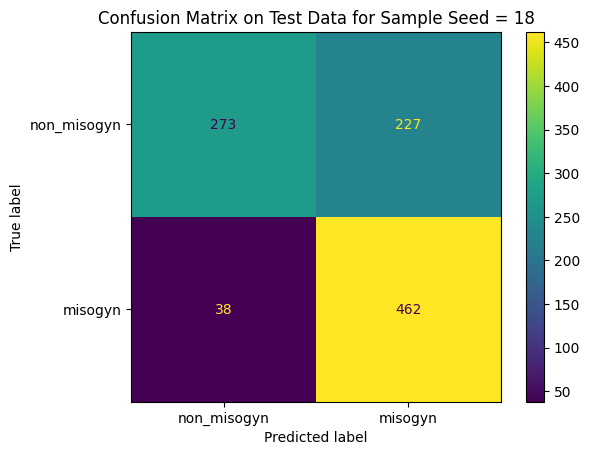

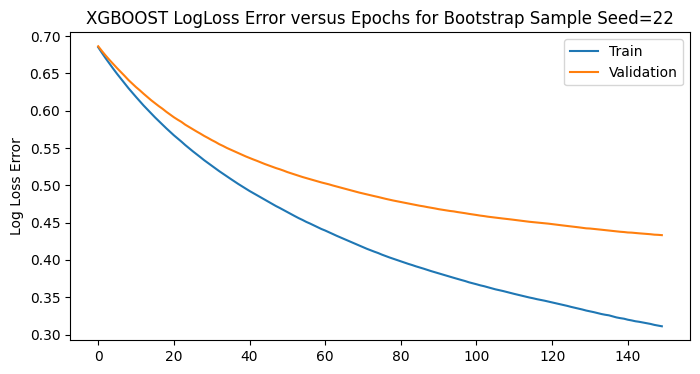

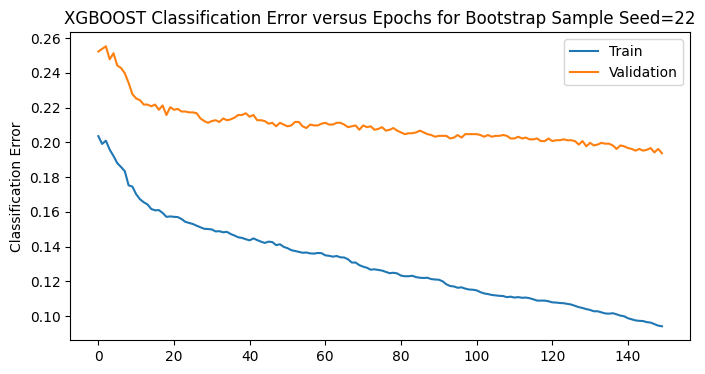

/tmp/ipykernel_9117/757353089.py:536: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  xgboost_clsfn_errrep = xgboost_clsfn_errrep.append(row_data, ignore_index=True)


              precision    recall  f1-score   support

           0       0.87      0.48      0.62       500
           1       0.64      0.93      0.76       500

    accuracy                           0.70      1000
   macro avg       0.75      0.70      0.69      1000
weighted avg       0.75      0.70      0.69      1000

Execution time: 297.7942008972168 seconds


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


train embeddings shape: (9986, 64)
test embeddings shape: (1000, 64)
transformer version: 4.15.0
cuda
NVIDIA GeForce RTX 3070 Laptop GPU
Memory Usage:
Allocated: 0.0 GB
Cached:    0.4 GB
len of common strings 9986
torch.Size([9986, 512])
Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 512)]        0           []                               
                                                                                                  
 dense_20 (Dense)               (None, 128)          65664       ['encoder_input[0][0]']          
                                                                                                  
 dropout_8 (Dropout)            (None, 128)          0           ['dense_20[0][0]']               
                                                        

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Fusion Embeddings Train (9986, 192)
Fusion Embeddings Test (1000, 192)
[0]	validation_0-error:0.21758	validation_0-logloss:0.68527	validation_1-error:0.24675	validation_1-logloss:0.68618
[1]	validation_0-error:0.20982	validation_0-logloss:0.67761	validation_1-error:0.24875	validation_1-logloss:0.67949
[2]	validation_0-error:0.19792	validation_0-logloss:0.67024	validation_1-error:0.24124	validation_1-logloss:0.67312
[3]	validation_0-error:0.19404	validation_0-logloss:0.66304	validation_1-error:0.24725	validation_1-logloss:0.66720
[4]	validation_0-error:0.18991	validation_0-logloss:0.65602	validation_1-error:0.24324	validation_1-logloss:0.66113
[5]	validation_0-error:0.18640	validation_0-logloss:0.64926	validation_1-error:0.23674	validation_1-logloss:0.65553
[6]	validation_0-error:0.18065	validation_0-logloss:0.64261	validation_1-error:0.23373	validation_1-logloss:0.64993
[7]	validation_0-error:0.17789	validation_0-logloss:0.63619	validation_1-error:0.23523	validation_1-logloss:0.64454
[

[70]	validation_0-error:0.12256	validation_0-logloss:0.41226	validation_1-error:0.20070	validation_1-logloss:0.47637
[71]	validation_0-error:0.12206	validation_0-logloss:0.41027	validation_1-error:0.20070	validation_1-logloss:0.47514
[72]	validation_0-error:0.12243	validation_0-logloss:0.40837	validation_1-error:0.19870	validation_1-logloss:0.47402
[73]	validation_0-error:0.12168	validation_0-logloss:0.40636	validation_1-error:0.19920	validation_1-logloss:0.47268
[74]	validation_0-error:0.12068	validation_0-logloss:0.40447	validation_1-error:0.19870	validation_1-logloss:0.47149
[75]	validation_0-error:0.12030	validation_0-logloss:0.40256	validation_1-error:0.19920	validation_1-logloss:0.47038
[76]	validation_0-error:0.11943	validation_0-logloss:0.40082	validation_1-error:0.19920	validation_1-logloss:0.46921
[77]	validation_0-error:0.11968	validation_0-logloss:0.39899	validation_1-error:0.20020	validation_1-logloss:0.46825
[78]	validation_0-error:0.11905	validation_0-logloss:0.39720	val

[140]	validation_0-error:0.09652	validation_0-logloss:0.32086	validation_1-error:0.19019	validation_1-logloss:0.42701
[141]	validation_0-error:0.09602	validation_0-logloss:0.32007	validation_1-error:0.18919	validation_1-logloss:0.42670
[142]	validation_0-error:0.09514	validation_0-logloss:0.31924	validation_1-error:0.18969	validation_1-logloss:0.42630
[143]	validation_0-error:0.09577	validation_0-logloss:0.31849	validation_1-error:0.18819	validation_1-logloss:0.42586
[144]	validation_0-error:0.09552	validation_0-logloss:0.31749	validation_1-error:0.18569	validation_1-logloss:0.42534
[145]	validation_0-error:0.09502	validation_0-logloss:0.31648	validation_1-error:0.18669	validation_1-logloss:0.42487
[146]	validation_0-error:0.09452	validation_0-logloss:0.31549	validation_1-error:0.18569	validation_1-logloss:0.42446
[147]	validation_0-error:0.09477	validation_0-logloss:0.31477	validation_1-error:0.18569	validation_1-logloss:0.42411
[148]	validation_0-error:0.09452	validation_0-logloss:0.

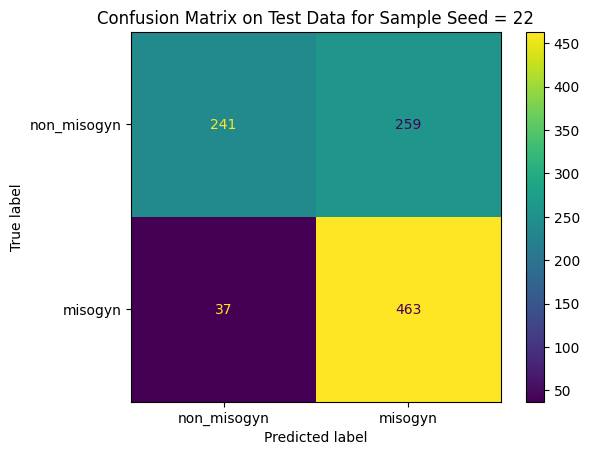

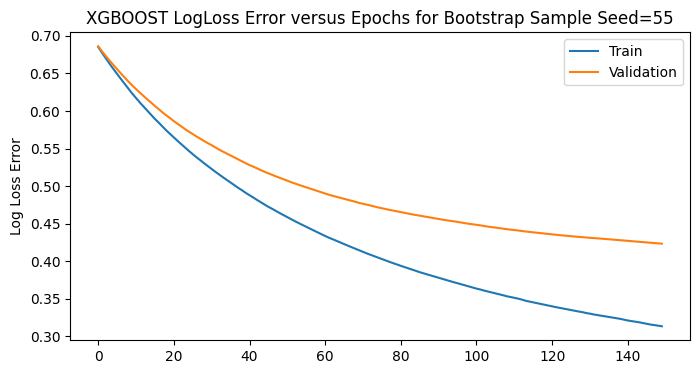

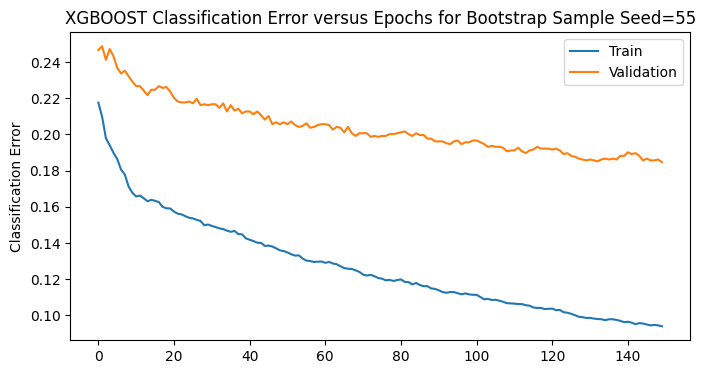

/tmp/ipykernel_9117/757353089.py:536: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  xgboost_clsfn_errrep = xgboost_clsfn_errrep.append(row_data, ignore_index=True)


              precision    recall  f1-score   support

           0       0.86      0.50      0.63       500
           1       0.65      0.92      0.76       500

    accuracy                           0.71      1000
   macro avg       0.75      0.71      0.70      1000
weighted avg       0.75      0.71      0.70      1000

Execution time: 308.55401945114136 seconds


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


train embeddings shape: (9986, 64)
test embeddings shape: (1000, 64)
transformer version: 4.15.0
cuda
NVIDIA GeForce RTX 3070 Laptop GPU
Memory Usage:
Allocated: 0.0 GB
Cached:    0.4 GB
len of common strings 9986
torch.Size([9986, 512])
Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 512)]        0           []                               
                                                                                                  
 dense_25 (Dense)               (None, 128)          65664       ['encoder_input[0][0]']          
                                                                                                  
 dropout_10 (Dropout)           (None, 128)          0           ['dense_25[0][0]']               
                                                        

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Fusion Embeddings Train (9986, 192)
Fusion Embeddings Test (1000, 192)
[0]	validation_0-error:0.18903	validation_0-logloss:0.68424	validation_1-error:0.25225	validation_1-logloss:0.68576
[1]	validation_0-error:0.18102	validation_0-logloss:0.67556	validation_1-error:0.24024	validation_1-logloss:0.67840
[2]	validation_0-error:0.18065	validation_0-logloss:0.66726	validation_1-error:0.22973	validation_1-logloss:0.67132
[3]	validation_0-error:0.17213	validation_0-logloss:0.65923	validation_1-error:0.22022	validation_1-logloss:0.66455
[4]	validation_0-error:0.17213	validation_0-logloss:0.65147	validation_1-error:0.22322	validation_1-logloss:0.65812
[5]	validation_0-error:0.17138	validation_0-logloss:0.64398	validation_1-error:0.22272	validation_1-logloss:0.65192
[6]	validation_0-error:0.16550	validation_0-logloss:0.63669	validation_1-error:0.21822	validation_1-logloss:0.64591
[7]	validation_0-error:0.16675	validation_0-logloss:0.62961	validation_1-error:0.21822	validation_1-logloss:0.64004
[

[70]	validation_0-error:0.12919	validation_0-logloss:0.40003	validation_1-error:0.20821	validation_1-logloss:0.47371
[71]	validation_0-error:0.12894	validation_0-logloss:0.39803	validation_1-error:0.20821	validation_1-logloss:0.47261
[72]	validation_0-error:0.12807	validation_0-logloss:0.39630	validation_1-error:0.20721	validation_1-logloss:0.47143
[73]	validation_0-error:0.12744	validation_0-logloss:0.39439	validation_1-error:0.20771	validation_1-logloss:0.47057
[74]	validation_0-error:0.12794	validation_0-logloss:0.39259	validation_1-error:0.20520	validation_1-logloss:0.46946
[75]	validation_0-error:0.12769	validation_0-logloss:0.39070	validation_1-error:0.20621	validation_1-logloss:0.46844
[76]	validation_0-error:0.12732	validation_0-logloss:0.38901	validation_1-error:0.20671	validation_1-logloss:0.46738
[77]	validation_0-error:0.12631	validation_0-logloss:0.38738	validation_1-error:0.20520	validation_1-logloss:0.46640
[78]	validation_0-error:0.12657	validation_0-logloss:0.38550	val

[140]	validation_0-error:0.10491	validation_0-logloss:0.30859	validation_1-error:0.20520	validation_1-logloss:0.43061
[141]	validation_0-error:0.10403	validation_0-logloss:0.30760	validation_1-error:0.20520	validation_1-logloss:0.43023
[142]	validation_0-error:0.10416	validation_0-logloss:0.30662	validation_1-error:0.20420	validation_1-logloss:0.42984
[143]	validation_0-error:0.10391	validation_0-logloss:0.30572	validation_1-error:0.20320	validation_1-logloss:0.42944
[144]	validation_0-error:0.10353	validation_0-logloss:0.30484	validation_1-error:0.20220	validation_1-logloss:0.42918
[145]	validation_0-error:0.10253	validation_0-logloss:0.30390	validation_1-error:0.20270	validation_1-logloss:0.42895
[146]	validation_0-error:0.10203	validation_0-logloss:0.30295	validation_1-error:0.20220	validation_1-logloss:0.42869
[147]	validation_0-error:0.10090	validation_0-logloss:0.30209	validation_1-error:0.20220	validation_1-logloss:0.42839
[148]	validation_0-error:0.10103	validation_0-logloss:0.

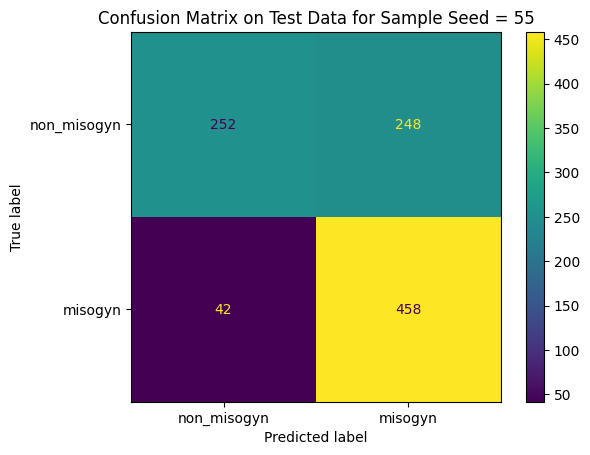

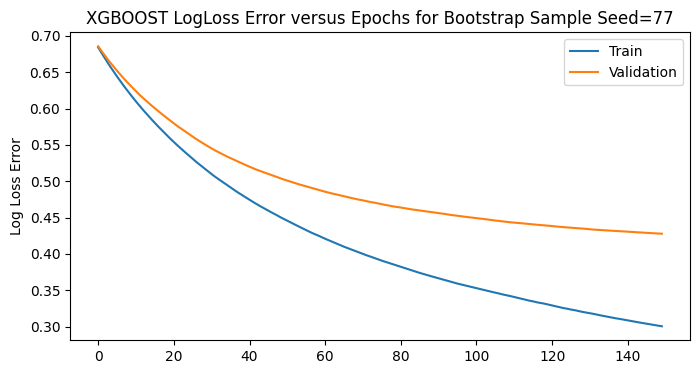

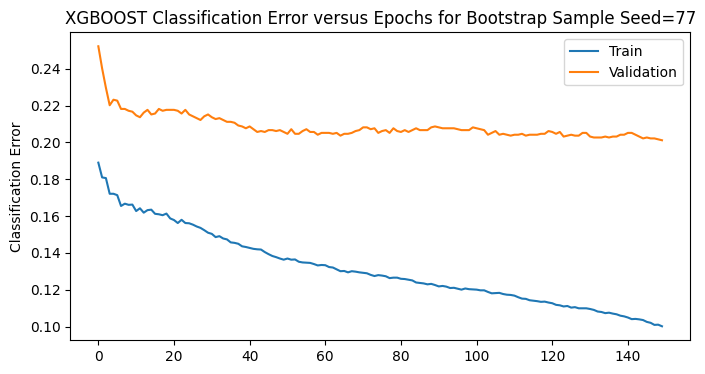

              precision    recall  f1-score   support

           0       0.85      0.50      0.63       500
           1       0.65      0.91      0.76       500

    accuracy                           0.71      1000
   macro avg       0.75      0.71      0.69      1000
weighted avg       0.75      0.71      0.69      1000

Execution time: 289.19757652282715 seconds


/tmp/ipykernel_9117/757353089.py:536: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  xgboost_clsfn_errrep = xgboost_clsfn_errrep.append(row_data, ignore_index=True)


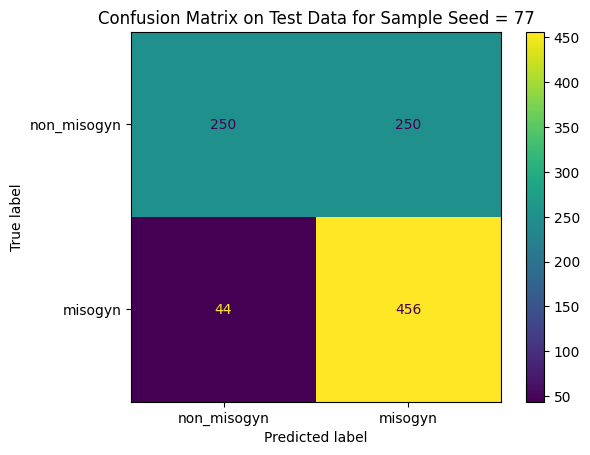

In [6]:
### TRAINING

df_BLPCLPXGB = pd.DataFrame(columns=['Model', 'Accuracy', 
                       'M-Precision', 'M-Recall', 
                       'M-F1-Score', 'W-Precision',
                       'W-Recall', 'W-F1-Score', 'Runtime'])

mse_val1 = []
KL_LOSS1 = []

# Store results in DataFrame
xgboost_clsfn_errrep  = pd.DataFrame(columns=["Bootstrap_Sample_Seed", "Train_LogLoss",
                                              "Validation_LogLoss", "Train_Error",
                                              "Validation_Error"])



for KK in list([7,10,18,22,55,77]):
    
    start_time = time.time()

    random.seed(KK)
    np.random.seed(KK)
    torch.manual_seed(KK)
    tf.random.set_seed(KK)


    device = "cpu"
    tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
#     tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
    model = DistilBertModel.from_pretrained("distilbert-base-uncased")
    model.to(device)
    projection_layer = torch.nn.Linear(768, 64)  # Add a linear layer to project embeddings to size 64
    projection_layer.to(device)

    train_encodings = tokenizer(
        train["text"].apply(apply_text_perturbation).tolist(),
        padding=True,
        max_length=20,
        truncation=True,
        return_tensors="pt"
    )

    test_encodings = tokenizer(
        test["text"].tolist(),
        padding=True,
        max_length=20,
        truncation=True,
        return_tensors="pt"
    )


    with torch.no_grad():
        train_outputs = model(**train_encodings.to(device))
        train_embeddings = train_outputs.last_hidden_state[:, 0, :]  # Extract embeddings for the [CLS] token
        train_embeddings = projection_layer(train_embeddings)  # Project embeddings to size 65

        test_outputs = model(**test_encodings.to(device))
        test_embeddings = test_outputs.last_hidden_state[:, 0, :]  # Extract embeddings for the [CLS] token
        test_embeddings = projection_layer(test_embeddings)  # Project embeddings to size 65

    train_embeddings = train_embeddings.cpu().numpy()
    test_embeddings = test_embeddings.cpu().numpy()

    print("train embeddings shape:", train_embeddings.shape)
    print("test embeddings shape:", test_embeddings.shape)





    # CLIP Image Embeddings (Training Image Embeddings)

    print('transformer version:', transformers.__version__)
    # !git clone https://github.com/salesforce/BLIP
    # Ref: https://github.com/salesforce/BLIP



    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(device)
    #Additional Info when using cuda
    if device.type == 'cuda':
        print(torch.cuda.get_device_name(0))
        print('Memory Usage:')
        print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
        print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

    #  watch -n 2 nvidia-smi


    # model_16

    # Define the directory containing the images
    IDs = []  #set1
    images = []
    image_dir = "./TRAINING"
    # # Load the data
    train2 = pd.read_csv('./training1.csv', delimiter='\t')

    # Get a list of image filenames in the directory
    filenames = natsort.natsorted(os.listdir(image_dir))
    # len(image_filenames)

    # Correct the images as some images are not having 3 channels.Omit such images.
    # get the ids from the images, where images are having three channels; omit images if channels != 3
    for i, filename in enumerate(filenames):
        if filename.endswith(".jpg"):
    #         ID = int(filename[:-4])
            ID = filename
            pathname = os.path.join(image_dir, filename)
            im = Image.open(pathname)
    #         print(im.size)
            im = im.resize((224, 224))  # Resize the image to (224, 224)
            imnp = np.array(im)
            if len(imnp.shape) != 3:
    #             print("This is 1 channel, so we omit it", imnp.shape, filename)
                continue
            IDs.append(ID)
            images.append(imnp)


    # Align the image and textual data and extract where we have both available 
    def get_common_strings(list1, list2):
        return list(set(list1) & set(list2))

    # Example usage
    list1 = IDs
    list2 = list(train2.file_name)  #from the text file where we have text description 
    common_strings = get_common_strings(list1, list2)
    print('len of common strings', len(common_strings))

    image_filenames = natsort.natsorted(common_strings)
    # display(image_filenames)

    import pandas as pd

    train_labelset = train2[['file_name', 'misogynous']]
    IDs_df = pd.DataFrame({'file_name': image_filenames})
    joined_df = IDs_df.merge(train_labelset, on='file_name', how='left')
    misogynous_labels = joined_df['misogynous'].tolist()


    # Create an empty list to store the image features
    all_image_features_16 = []


    model_16, preprocess_16 = clip.load('ViT-B/16', device=device)

    # Process each image and extract features
    for filename in image_filenames:
        image_path = os.path.join(image_dir, filename)

        # Preprocess the image
        image_16 = preprocess_16(Image.open(image_path)).unsqueeze(0).to(device)

        # Encode the image features
        with torch.no_grad():
            image_features_16 = model_16.encode_image(image_16)

        # Append the image features to the list
        all_image_features_16.append(image_features_16)

    # Concatenate the image features into a single tensor
    all_image_features_16 = torch.cat(all_image_features_16, dim=0)
    print(all_image_features_16.shape)
    # torch.Size([9986, 512])



    ## REDUCE 512 EMBEDDING SIZE TO 64 EMBEDDING SIZE #####
    #######################################################

    random.seed(KK)
    np.random.seed(KK)
    torch.manual_seed(KK)
    tf.random.set_seed(KK)

    embedding_size = 64
    all_image_features_16_cpu = all_image_features_16.cpu()
    all_image_features_16_numpy = all_image_features_16_cpu.numpy()



    ## using the below Sampling class from WK08 lab tutorials. 
    class Sampling(layers.Layer):


        """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit.
            Sampling from the distribution of z_mu and z_var helps in 
            generating new point in latent space which we can pass to the decoder network 
            to reconstruct the data samples similar to original input
        """
        def call(self, inputs):

            #the encoder network produces a mean and a variance for each dimension of the latent space.
            z_mean, z_log_var = inputs

            # epsilon is not a weight (ie is not learned) and is not calculated based on 
            # the output of the previous layer.
            # epsilon is just a constant Tensor (a new one, each time we call this layer).


            epsilon = K.random_normal(shape=tf.shape(z_mean)) # N(0, 1)
            return z_mean + K.exp(0.5 * z_log_var) * epsilon # N(mu, sigma)


    # for the encoder part, now the original dimension would be the pretrained model output flattened features
    # dimension
    original_dim = all_image_features_16_numpy.shape[1] 
    intermediate_dim = 128  
    intermediate_dim_1 = 64

    latent_dim = embedding_size  # i.e. 18, we set latent dimension to be of embedding size i.e. 18.

    # Define Input to the encoder 
    #Encoder Model Structure
    original_inputs = layers.Input(shape=(original_dim,), name="encoder_input")
    x = layers.Dense(intermediate_dim, activation="relu")(original_inputs)
    x = Dropout(0.0001)(x) # add dropout with  tiny probability because data is small
    x = layers.Dense(intermediate_dim_1, activation="relu")(x)
    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
    z = Sampling()((z_mean, z_log_var))   #updated
    encoder = models.Model(inputs=original_inputs, outputs=z, name="encoder") 
    # encoder = models.Model(inputs=original_inputs, outputs=[z_mean, z_log_var], name="encoder")


    #decoder model
    latent_inputs = layers.Input(shape=(latent_dim,), name="z_sampling")
    x = layers.Dense(intermediate_dim_1, activation="relu")(latent_inputs)
    x = Dropout(0.0001)(x) # add dropout with  tiny probability because data is small
    x = layers.Dense(intermediate_dim, activation="relu")(x)
    outputs = layers.Dense(original_dim, activation="sigmoid")(x)
    decoder = models.Model(inputs=latent_inputs, outputs=outputs, name="decoder")

    # z = Sampling()((z_mean, z_log_var))
    outputs = decoder(z)
    vae = models.Model(inputs=original_inputs, outputs=outputs, name="vae")
    vae.summary()

    #get the reconstruction loss
    reconstruction_loss = mse(original_inputs, outputs) # xhat should match x
    reconstruction_loss = original_dim * K.mean(reconstruction_loss)

    # regularization KL divergence term encourages the learned latent space to be a smooth manifold.
    kl_loss = -0.5 * tf.reduce_mean(
        z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)
    vae.add_loss(kl_loss)
    vae.add_metric(kl_loss, name='kl_loss', aggregation='mean')
    vae.add_loss(reconstruction_loss)
    vae.add_metric(reconstruction_loss, name='mse_loss', aggregation='mean')

    # set Adam optimizer with learning ate 0.001
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

    #Compile the model 
    vae.compile(optimizer)

    # Train. x_train is both the "x" and the "y"
    # vae.fit(flat_features, flat_features, epochs=10)

    random.seed(KK)
    np.random.seed(KK)
    torch.manual_seed(KK)
    tf.random.set_seed(KK)

    vaemod = vae.fit(all_image_features_16_numpy, all_image_features_16_numpy, epochs=10)
    # Increasing the epochs performing badly when we run k-neareast neighbour to achieve the 
    # nearest posters. 

    #In this code, we first need to build the vae model before using encoder.predict(). 
    #This is because the encoder model is a part of the vae model and needs to be built first.

    ## KL LOSS

    KL_LOSS =  vaemod.history['kl_loss']

    KL_LOSS1.append(KL_LOSS)

    mse_val =  vaemod.history['mse_loss']
    print(mse_val)

    mse_val1.append(mse_val)


    latent_emb = encoder.predict(all_image_features_16_numpy)  
    # z_mean, z_log_var = encoder.predict(all_image_features_16_numpy)
    # latent_emb = Sampling()((z_mean, z_log_var))
    print(latent_emb.shape) 

    #Additional Info when using cuda
    if device.type == 'cuda':
        print(torch.cuda.get_device_name(0))
        print('Memory Usage:')
        print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
        print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')





    # CLIP Image Embeddings (Test Image Embeddings)

    # TEST DATA IMAGES LOADING


    TEST_IDs = []  #set1
    TEST_images = []
    TEST_directory = './TEST'   # directory where we have images 
    test_filenames = natsort.natsorted(os.listdir(TEST_directory))  

    # Correct the images as some images are not having 3 channels.Omit such images.
    # get the ids from the images, where images are having three channels; omit images if channels != 3
    for i, filename in enumerate(test_filenames):
    #     print(i, filename)
        if filename.endswith(".jpg"):
    #         ID = int(filename[:-4])
            TEST_ID = filename
            pathname = os.path.join(TEST_directory, filename)
            im = Image.open(pathname)
            im = im.resize((224, 224))  # Resize the image to (224, 224)
            TEST_imnp = np.array(im)
            if len(TEST_imnp.shape) != 3:
    #             print("This is 1 channel, so we omit it", TEST_imnp.shape, filename)
                continue
            TEST_IDs.append(TEST_ID)
            TEST_images.append(TEST_imnp)


    # Align the image and textual data and extract where we have both available 
    def get_common_strings(list1, list2):
        return list(set(list1) & set(list2))

    # Example usage
    TEST_list1 = TEST_IDs
    TEST_list2 = list(test2.file_name)  #from the text file where we have text description 
    TEST_common_strings = get_common_strings(TEST_list1, TEST_list2)
    print('len of common strings', len(TEST_common_strings))

    TEST_sorted_ids = natsort.natsorted(TEST_common_strings)
    # len(TEST_sorted_ids)


    TEST_IDs1 = []
    TEST_images1 = [] 
    # Correct the images as some images are not having 3 channels.Omit such images.
    # get the ids from the images, where images are having three channels; omit images if channels != 3
    for i, filename in enumerate(TEST_sorted_ids):
    #     print(i, filename)
        if filename.endswith(".jpg"):
            TEST_ID_0 = filename
            pathname = os.path.join(TEST_directory, filename)
            im = Image.open(pathname)
            im = im.resize((224, 224))  # Resize the image to (224, 224)
            TEST_1_imnp = np.array(im)
            if len(TEST_1_imnp.shape) != 3:
    #             print("This is 1 channel, so we omit it", TEST_1_imnp.shape, filename)
                continue
    #         print('Filename', TEST_ID_0)
            TEST_IDs1.append(TEST_ID_0)
            TEST_images1.append(TEST_1_imnp)


    len(TEST_images1), len(TEST_IDs1)


    #### TEST EMBEDDINGS #####
    clip_test_embeddings = []

    for image in TEST_images1:
        # Preprocess the image
        image_tensor = preprocess_16(Image.fromarray(image)).unsqueeze(0).to(device)

        # Encode the image features
        with torch.no_grad():
            image_features = model_16.encode_image(image_tensor)

        # Append the image features to the list
        clip_test_embeddings.append(image_features)

    clip_test_embeddings = torch.cat(clip_test_embeddings, dim=0)

    # Move the test embeddings tensor to the CPU
    clip_test_embeddings = clip_test_embeddings.cpu()

    # Convert the test embeddings tensor to a NumPy array
    clip_test_embeddings_np = clip_test_embeddings.numpy()

    # Use the existing encoder to reduce the dimensions of the test embeddings
    reduced_test_embeddings  = encoder.predict(clip_test_embeddings_np)
    # z_mean_clipmod, z_log_var_clipmod = encoder.predict(clip_test_embeddings_np)
    # reduced_test_embeddings = Sampling()((z_mean_clipmod, z_log_var_clipmod))

    print('Image Test Embeddings Dimension', reduced_test_embeddings.shape)



    if os.getcwd() != "/home/nitesh/Documents/MY_THESIS/MAMI/BLIP":
        %cd BLIP
    print(os.getcwd())

    # Load the training captions data and test captions data files. 
    train_capn = pd.read_csv('train_BLIP_captions.csv')

    test_capn = pd.read_csv('test_BLIP_captions.csv')
    

    ###########################################################

    # Apply text perturbation to the training captions
    train_capn["text"] = train_capn["text"].apply(apply_text_perturbation)


    ############################################################

    random.seed(KK)
    np.random.seed(KK)
    torch.manual_seed(KK)
    tf.random.set_seed(KK)

    print('transformer version:', transformers.__version__)
    # !git clone https://github.com/salesforce/BLIP
    # Ref: https://github.com/salesforce/BLIP

    from transformers import DistilBertTokenizer, DistilBertModel
    tokenizer1 = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
    model1 = DistilBertModel.from_pretrained("distilbert-base-uncased")


    device = "cpu"
    model1.to(device)
    projection_layer1 = torch.nn.Linear(768, 64)  # Add a linear layer to project embeddings to size 64
    projection_layer1.to(device)

    train_encodings1 = tokenizer1(
        train_capn["text"].tolist(),
        padding=True,
        max_length=50,
        truncation=True,
        return_tensors="pt"
    )

    test_encodings1 = tokenizer1(
        test_capn["text"].tolist(),
        padding=True,
        max_length=50,
        truncation=True,
        return_tensors="pt"
    )

    with torch.no_grad():
        train_outputs1 = model1(**train_encodings1.to(device))
        train_embeddings1 = train_outputs1.last_hidden_state[:, 0, :]  # Extract embeddings for the [CLS] token
        train_embeddings1 = projection_layer1(train_embeddings1)  # Project embeddings to size 65

        test_outputs1 = model1(**test_encodings1.to(device))
        test_embeddings1 = test_outputs1.last_hidden_state[:, 0, :]  # Extract embeddings for the [CLS] token
        test_embeddings1 = projection_layer1(test_embeddings1)  # Project embeddings to size 65


    # Concatenate the text and image embeddings
    fusion_embeddings_train = np.concatenate((train_embeddings, latent_emb, train_embeddings1), axis=1)
    print('Fusion Embeddings Train', fusion_embeddings_train.shape)


    # Concatenate the text and image embeddings
    fusion_embeddings_test = np.concatenate((test_embeddings, reduced_test_embeddings, test_embeddings1), 
                                            axis=1)
    print('Fusion Embeddings Test', fusion_embeddings_test.shape)


    import pickle
    # Save the embeddings as a pickle object
    pickle_path_train = f"/home/nitesh/Documents/MY_THESIS/MAMI/Triple_Fusion_Embeddings/fusion_embeddings_train_vowelperturb_aug_{KK}.pkl"
    with open(pickle_path_train, 'wb') as f:
        pickle.dump(fusion_embeddings_train, f)

    # Save the embeddings as a pickle object
    pickle_path_test = f"/home/nitesh/Documents/MY_THESIS/MAMI/Triple_Fusion_Embeddings/fusion_embeddings_test_vowelperturb_aug_{KK}.pkl"
    with open(pickle_path_test, 'wb') as f:
        pickle.dump(fusion_embeddings_test, f)


    from sklearn.model_selection import train_test_split
    import xgboost as xgb 
    train_lbls = train.label.map({'non_misogyn': 0, 'misogyn': 1})

    X_train, X_test, y_train, y_test = train_test_split(fusion_embeddings_train, train_lbls, 
                                                        test_size=0.20, random_state=7)

    # Initialize the XGBoost Classifier
    xgb_classifier = xgb.XGBClassifier(n_estimators=150, learning_rate=0.02)

    eval_set = [(X_train, y_train), (X_test, y_test)]
    xgb_classifier.fit(X_train, y_train, eval_metric=["error", "logloss"], eval_set=eval_set, verbose=True)

    from matplotlib import pyplot
    import matplotlib.pyplot as plt

    results = xgb_classifier.evals_result()
    epochs = len(results["validation_0"]["error"])
    x_axis = range(0, epochs)


    # plot log loss
    fig, ax = pyplot.subplots(figsize=(8,4))
    ax.plot(x_axis, results["validation_0"]["logloss"], label="Train")
    ax.plot(x_axis, results["validation_1"]["logloss"], label="Validation")
    ax.legend()
    pyplot.ylabel("Log Loss Error")
    pyplot.title(f'XGBOOST LogLoss Error versus Epochs for Bootstrap Sample Seed={KK}')
    plot_path = '/home/nitesh/Documents/MY_THESIS/MAMI/Plots/'
    plt.savefig(plot_path + f'XGB00ST_LogLoss_Error_{KK}.png')
    pyplot.show()

    # plot classification error
    fig, ax = pyplot.subplots(figsize=(8,4))
    ax.plot(x_axis, results["validation_0"]["error"], label="Train")
    ax.plot(x_axis, results["validation_1"]["error"], label="Validation")
    ax.legend()
    pyplot.ylabel("Classification Error")
    pyplot.title(f'XGBOOST Classification Error versus Epochs for Bootstrap Sample Seed={KK}')
    plot_path = '/home/nitesh/Documents/MY_THESIS/MAMI/Plots/'
    plt.savefig(plot_path + f'XGB00ST_Classification_Error_{KK}.png')
    pyplot.show()


    row_data = {
        "Bootstrap_Sample_Seed": KK,
        "Train_LogLoss": results["validation_0"]["logloss"],
        "Validation_LogLoss": results["validation_1"]["logloss"],
        "Train_Error": results["validation_0"]["error"],
        "Validation_Error": results["validation_1"]["error"]
    }
    xgboost_clsfn_errrep = xgboost_clsfn_errrep.append(row_data, ignore_index=True)


    # Make predictions on the test set
    from sklearn.metrics import classification_report 

    y_pred = xgb_classifier.predict(fusion_embeddings_test)
    # test_lbls = test.label

    test_lbls = test.label.map({'non_misogyn': 0, 'misogyn': 1})
    print(classification_report(test_lbls, y_pred))
    #     print(classification_report(test["label"].tolist(), y_pred))

    report_clip_blip_xgboost = classification_report(test_lbls, y_pred, digits=3)
    #     report_clip_blip_xgboost = classification_report(test["label"].tolist(), y_pred, digits=3)
    #     print(classification_report(test["label"].tolist(), y_pred))


    end_time = time.time()
    execution_time1 = end_time - start_time

    print(f"Execution time: {execution_time1} seconds")

    
    #######
    confusion_matrix = plot_confusion_matrix(xgb_classifier, fusion_embeddings_test, 
                                                 test_lbls,display_labels=['non_misogyn', 'misogyn'])
    plt.title(f'Confusion Matrix on Test Data for Sample Seed = {KK}')
    

    modname = 'DistilBERT_ViT_VAE_BLIP_XGBOOST_VOWELPERTURB'
    df1 = export_classification_report(report_clip_blip_xgboost, modname, execution_time1)
    df_BLPCLPXGB = pd.concat([df_BLPCLPXGB, df1])
    
    os.chdir("/home/nitesh/Documents/MY_THESIS/MAMI")

    del start_time, tokenizer, model, projection_layer, confusion_matrix
    del train_encodings, test_encodings, train_outputs, test_outputs
    del train_embeddings, test_embeddings
    del IDs, images, image_dir, train2, filenames, common_strings, image_filenames
    del train_labelset, IDs_df, joined_df, misogynous_labels
    del all_image_features_16, model_16, preprocess_16
    del all_image_features_16_cpu, all_image_features_16_numpy
    del Sampling, original_dim, intermediate_dim, intermediate_dim_1, latent_dim
    del original_inputs, x, z_mean, z_log_var, z, encoder
    del latent_inputs, outputs, decoder, vae, optimizer, reconstruction_loss, kl_loss
    del latent_emb, TEST_IDs, TEST_images, TEST_directory, test_filenames, TEST_common_strings
    del TEST_sorted_ids, TEST_IDs1, TEST_images1, clip_test_embeddings, clip_test_embeddings_np
    del reduced_test_embeddings, train_capn, test_capn

    # display(xgboost_clsfn_errrep)


A bootstrap sample is a random sample taken with replacement from a dataset. It is a common resampling technique used in statistics and machine learning.

When creating a bootstrap sample, you randomly select observations from the original dataset, allowing for duplicate selections (sampling with replacement). The size of the bootstrap sample is usually the same as the size of the original dataset, although it can be smaller or larger depending on the specific use case.

The purpose of bootstrap sampling is to estimate the sampling distribution or variability of a statistic calculated on the original dataset. By generating multiple bootstrap samples and calculating the statistic of interest for each sample, you can obtain an empirical estimate of the sampling distribution. This information can be useful for constructing confidence intervals, assessing the stability of statistical estimates, and performing hypothesis testing.

Bootstrap sampling allows you to obtain insights into the variability and uncertainty associated with a dataset and its statistical estimates without making strict assumptions about the underlying population distribution.

In [7]:
# Define the CSV file path
csv_file = '/home/nitesh/Documents/MY_THESIS/MAMI/Plots/7_xgboost_clsfn_errrep_VOWELPERTURB.csv'

xgboost_clsfn_errrep.to_csv(csv_file, index=False)


In [8]:
# df_BLPCLPXGB
# mse_val1[0]

1. how to change the epochs in xgb? 
2. how to get the error log results in a table or csv?

## VAE TRAINING LOSS VS EPOCH PLOT [SAVE PLOT]

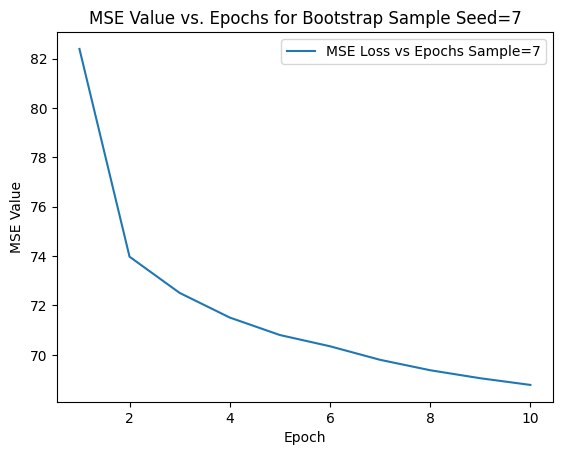

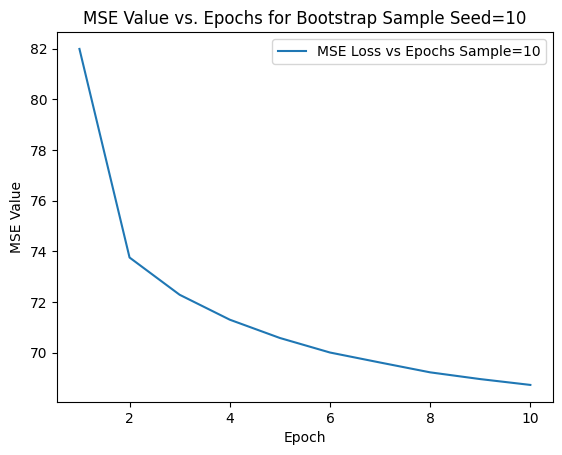

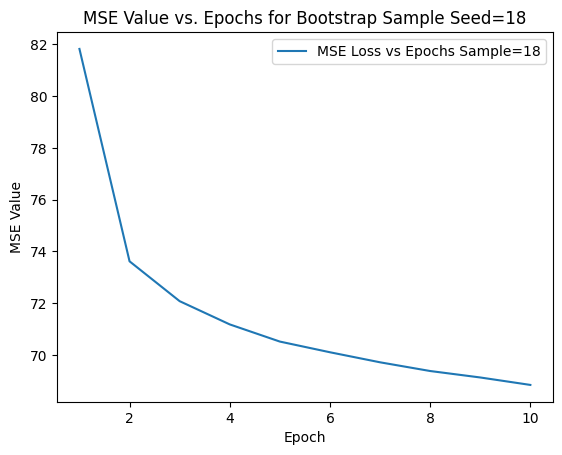

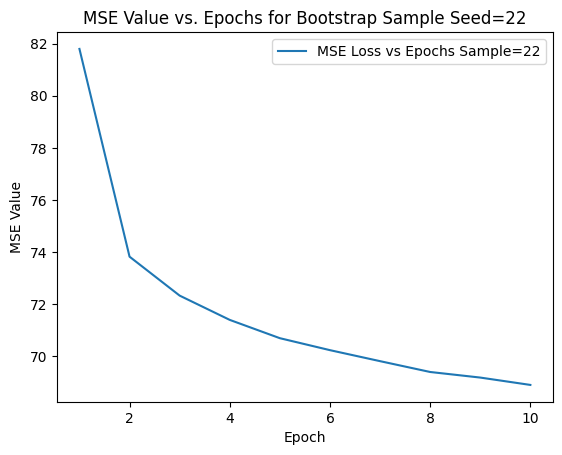

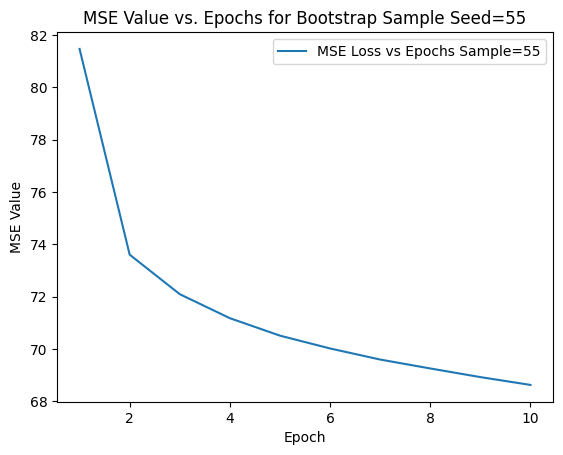

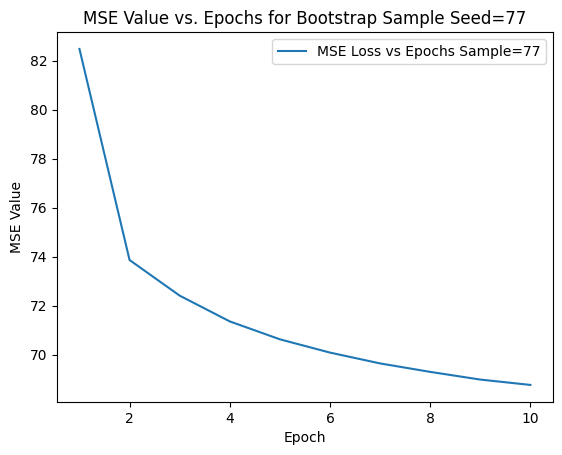

In [9]:
num_lists = len(mse_val1)  # Number of lists
epochs_vae = range(1, 11)  # Epochs (assuming 10 epochs)


# Plot each list in mse_val1
for i, j in zip(range(num_lists), list([7,10,18,22,55,77])):         
    plt.plot(epochs_vae, mse_val1[i], label=f'MSE Loss vs Epochs Sample={j}')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Value')
    plt.title(f'MSE Value vs. Epochs for Bootstrap Sample Seed={j}')
    plot_path = '/home/nitesh/Documents/MY_THESIS/MAMI/Plots/'
    plt.savefig(plot_path + f'7_VAE_TrainingLoss_Epoch_Plot_VOWELPERTURB{j}.png')
    plt.legend()
    plt.show()
    plt.close()  # Close the connection 

# # Save the plots in the local directory
# for i in range(num_lists):
#     plt.savefig(f'plot_{i}.png')
#     plt.close()  # Cl

## SAVE MSE ERROR RESULTS CORRESPONDING TO VAE TRAINING 

In [10]:

# csv_file ='/home/nitesh/Documents/MY_THESIS/MAMI/Plots/VAE_MSE_VALUES'
# Write mse_val1 to CSV file
df = pd.DataFrame(mse_val1)

# Save the DataFrame to a CSV file
# df.to_csv(csv_file, index=False)

# Define the CSV file path
csv_file = '/home/nitesh/Documents/MY_THESIS/MAMI/Plots/7_VAE_training_loss_epochs_VOWELPERTURB.csv'

df.to_csv(csv_file, index=False)


In [11]:
df_BLPCLPXGB

,Model,Accuracy,M-Precision,M-Recall,M-F1-Score,W-Precision,W-Recall,W-F1-Score,Runtime
0,DistilBERT_ViT_VAE_BLIP_XGBOOST_VOWELPERTURB,0.694,0.747,0.694,0.677,0.747,0.694,0.677,474.528707
0,DistilBERT_ViT_VAE_BLIP_XGBOOST_VOWELPERTURB,0.714,0.755,0.714,0.702,0.755,0.714,0.702,449.780732
0,DistilBERT_ViT_VAE_BLIP_XGBOOST_VOWELPERTURB,0.735,0.774,0.735,0.725,0.774,0.735,0.725,308.293009
0,DistilBERT_ViT_VAE_BLIP_XGBOOST_VOWELPERTURB,0.704,0.754,0.704,0.689,0.754,0.704,0.689,297.794201
0,DistilBERT_ViT_VAE_BLIP_XGBOOST_VOWELPERTURB,0.710,0.753,0.710,0.697,0.753,0.710,0.697,308.554019
0,DistilBERT_ViT_VAE_BLIP_XGBOOST_VOWELPERTURB,0.706,0.748,0.706,0.693,0.748,0.706,0.693,289.197577


## SAVE THE CLASSIFICATION REPORT ERROR TO LOCAL 

In [12]:
df_BLPCLPXGB

,Model,Accuracy,M-Precision,M-Recall,M-F1-Score,W-Precision,W-Recall,W-F1-Score,Runtime
0,DistilBERT_ViT_VAE_BLIP_XGBOOST_VOWELPERTURB,0.694,0.747,0.694,0.677,0.747,0.694,0.677,474.528707
0,DistilBERT_ViT_VAE_BLIP_XGBOOST_VOWELPERTURB,0.714,0.755,0.714,0.702,0.755,0.714,0.702,449.780732
0,DistilBERT_ViT_VAE_BLIP_XGBOOST_VOWELPERTURB,0.735,0.774,0.735,0.725,0.774,0.735,0.725,308.293009
0,DistilBERT_ViT_VAE_BLIP_XGBOOST_VOWELPERTURB,0.704,0.754,0.704,0.689,0.754,0.704,0.689,297.794201
0,DistilBERT_ViT_VAE_BLIP_XGBOOST_VOWELPERTURB,0.710,0.753,0.710,0.697,0.753,0.710,0.697,308.554019
0,DistilBERT_ViT_VAE_BLIP_XGBOOST_VOWELPERTURB,0.706,0.748,0.706,0.693,0.748,0.706,0.693,289.197577


In [13]:
df_BLPCLPXGB.to_excel('7_classification_report_DistilBERT_ViT_VAE_BLIP_XGBOOST_VOWELPERTURB.xlsx', 
                      index=False)

https://xgboost.readthedocs.io/en/stable/parameter.html

refer aboev document for classification error and  logloss error